In [5]:
from dotenv import load_dotenv
load_dotenv('.env-db')
from utils.utils import get_database
from transformers import LlamaTokenizerFast
tokenizer = LlamaTokenizerFast.from_pretrained('hf-internal-testing/llama-tokenizer')
import pandas as pd
def count_tokens(prompt):
    return len(tokenizer.tokenize(prompt))

In [4]:
llm_to_index = {
    'openchat/openchat_v3.1': 0, 
    'OpenAssistant/llama2-13b-orca-8k-3319':1,
    'baichuan-inc/Baichuan-13B-Base': 2,
}
# llm_name = 'openchat/openchat_v3.1'
dim = 'authority'

### output formatting (0 index initial)

In [6]:
import numpy as np
db = get_database()
for llm_name in llm_to_index:
    all_ratings_llm = pd.DataFrame(list(db[f'queries/{llm_name}/{dim}'].find({})))
    all_ratings_llm['llm_index'] = llm_to_index[llm_name]
    try:
        all_ratings_llm = all_ratings_llm.drop(columns=['dim'])
        all_ratings_llm = all_ratings_llm.drop(columns=['dimnsion'])
    except:
        pass
    # combine prefix and prompt index into a single number
    all_ratings_llm = all_ratings_llm.assign(sample_index=lambda x: x.groupby(['sample_index']).ngroup())
    all_ratings_llm = all_ratings_llm.assign(item_index=lambda x: x.groupby(['prefix_index', 'prompt_index']).ngroup())
    # all_ratings_llm['rating'] = all_ratings_llm['rating'] + 1
    all_ratings_llm['rating'] = all_ratings_llm['rating'].replace(0, 1)
    all_ratings_llm['rating'] = all_ratings_llm['rating'].replace(list(range(11, 100)), 10)
    all_ratings_llm['rating'] = all_ratings_llm['rating'].replace(-100, -1)
    all_ratings_llm.to_csv(f'temp/contrast/{dim}_ratings_llm_{llm_to_index[llm_name]}.csv', index=False)

### final output for calibration format

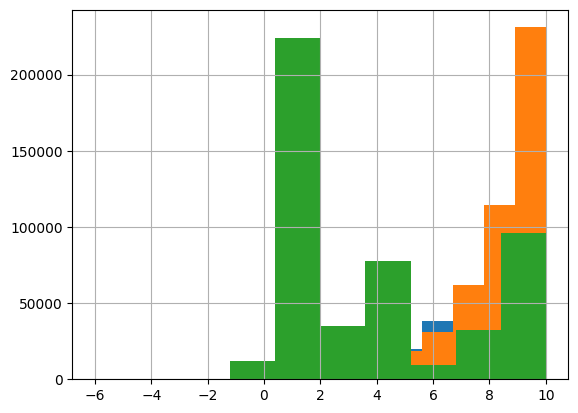

In [8]:
def add_index_range_series(series):
    # get in the format of 0-100, 100-200, etc.
    return series.min().astype(int).astype(str) + '-' + series.max().astype(int).astype(str) + 'a'
# all_ratings_llm = all_ratings_llm.drop(columns=['_id', 'prefix_index', 'prompt_index'])
for llm_name in llm_to_index:
    all_ratings_llm_formatted = pd.read_csv(f'temp/contrast/{dim}_ratings_llm_{llm_to_index[llm_name]}.csv')
    all_ratings_llm_formatted = all_ratings_llm_formatted.drop(columns=['num_tries', 'latency'])
    all_ratings_llm_formatted = all_ratings_llm_formatted.drop(columns=['_id', 'prefix_index', 'prompt_index'])
    all_ratings_llm_formatted['item_index'] +=1
    all_ratings_llm_formatted['llm_index'] +=1
    all_ratings_llm_formatted['sample_index'] +=1
    all_ratings_llm_formatted['rating'] = all_ratings_llm_formatted['rating'].astype(int).astype(str).replace('-1', '.')
    all_ratings_llm_formatted['rating'].replace('.', '-1').astype(int).hist(bins=10)
    all_ratings_llm_formatted = all_ratings_llm_formatted.sort_values('item_index')\
        .groupby(['sample_index', 'llm_index'])\
        .agg({'item_index': add_index_range_series, 'rating': list})\
        .reset_index()
    s = all_ratings_llm_formatted['rating']
    ratings_df = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
    all_ratings_llm_formatted = all_ratings_llm_formatted.drop(columns=['rating'])
    all_ratings_llm_formatted = pd.concat([all_ratings_llm_formatted, ratings_df], axis=1)
    all_ratings_llm_formatted.to_csv(f'temp/contrast/{dim}_ratings_llm_{llm_to_index[llm_name]}_formatted.csv', index=False, header=False)
